# Observable Trends:
----
## 1. As expected, temperatures begin to rise as we get closer to the equator.  However, it is more interesting to note that temeratures in the southern hermisphere are slightly warmer than temperatures in the northern hermisphere.  This is because it is currently winter in the northern hemisphere, while it is summer in the souther hermisphere.
## 2. Cloudiness is unrelated to latitude, but there are certain percentages with large bands of latitudes.  These bands happen particularly at 0%, 75%, and 90% cloudiness.
## 3. While the relationship between wind speed and latitude is weak, it can be seen that the northern hemisphere has a slightly greater representation of flurries.

# Sections:
----
## Part 1 - Generating Random Cities
## Part 2 - OpenWeatherMap API Scraping and Storage
## Part 3 - API Data Visualization

In [1]:
# Import dependencies
# API dependencie(s)
import requests
import json

# Data dependencie(s)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pip librarie(s)
from citipy import citipy

# Import API key (.gitignore file)
from keys import api_key

# Part 1 - Generating Random Cities
----
## This section does the following:
---
### 1. Run a numpy simulation to create a truly random set of 1500 latatitude and longitude combinations.  
### 2. Passes these latitudes and longitudes into the nearest_city method in the citipy library, which will return the closest city to the given latitude and longitude.
### 3. Creates a list of the unique cities determined in the simulation, as well as the associated latitudes for plotting later.

In [2]:
# Use numpy to create a range of random latitudes and longitudes and citipy to get a list of associated cities

# List for holding lat_lngs and cities
lat_lngs = []
cities = []
city_lat = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list, as well as the associated latitude
    if city not in cities:
        cities.append(city)
        city_lat.append(lat_lng[0])

# Create a dictionary of city and latitude pairs
cities_lat_dict = dict(zip(cities, city_lat))

# Part 2 - OpenWeatherMap API Scraping and Storage
----
## This section does the following:
---
### 1. Scrapes through OpenWeatherMap and uses cities from the "cities" list above as queries.
### 2. Prints whether or not the city determined from the simulation in part 1 exists in the API.
### 3. Stores information successfully scraped into a data frame "weather_report_df" and writes it to a csv.

In [3]:
# API scraping
# Initialize dictionary to store values 
result = {}

# Open an output file stream to store which cities existed within the API
log_file = open('api_retrieval_log.txt','w')

# Post a header to the log file
log_file.write("Beginning Data Retrieval" + "\n")
log_file.write("-----------------------------" + "\n")
# Begin data retieval for each random city
for index, val in enumerate(cities):
    # Begin exception handling in case city data is not recorded in the API
    try:
        # Make an API call
        query = f"http://api.openweathermap.org/data/2.5/weather?q={val}&appid={api_key}"
        json_response = requests.get(query).json()

        # Collect temperature data from api (API returns temp in K)
        temp_K = json_response["main"]["temp"]
        temp_F = (9/5) * (temp_K - 273) + 32

        # Collect humidity data (API return a percentage)
        humidity = json_response["main"]["humidity"]

        # Collect cloudiness data (API return a percentage)
        cloudiness = json_response["clouds"]["all"]

        # Collect Wind speed data (API provides units in m/s)
        wind_speed_m_s = json_response["wind"]["speed"]
        wind_speed_mph = wind_speed_m_s * 2.2369

        # Create a dictionary of the cities mapped to these scraped values
        result[val] = [temp_F, humidity,cloudiness,wind_speed_mph]
        
        # Print success of retrieval outcome to api_retrieval_log.txt
        log_file.write(f"Processing city {index+1} ({val})" + "\n")   
        
    # Print failure of retrieval outcome to api_retrieval_log.txt     
    except KeyError:
        log_file.write(f"No data for city {index+1} ({val}). Skipping..." + "\n")
        
# Close log_file stream
log_file.write("-----------------------------" + "\n")
log_file.write("Data Retrieval Complete" + "\n")
log_file.write("-----------------------------" + "\n")
log_file.close()

In [4]:
# Create a data frame that will show all the city data together

# Create a list of latitudes from the cities that we would collect data for
processed_lats = []
for key in result:
    processed_lats.append(cities_lat_dict[key])

# Create a data frame out of the result dictionary and processed_lats list
weather_report_df = pd.DataFrame.from_dict(result, orient='index')
weather_report_df["Latitude"] = processed_lats

# Clean up data frame
weather_report_df.index.names = ['Cities']
weather_report_df = weather_report_df.rename(columns ={0:"Temperature (F)",1:"Humidity (%)",\
                                                       2:"Cloudiness (%)", 3:"Wind Speed (mph)"})
weather_report_df["Temperature (F)"] = round(weather_report_df["Temperature (F)"],1)
weather_report_df["Wind Speed (mph)"] = round(weather_report_df["Wind Speed (mph)"],1)

# Print the weather report data frame to a csv
weather_report_df.to_csv("weather_report.csv", encoding='utf-8')

# Part 3 - API Data Visualization
----
## After scraping data from the API and storing the scraped data into a data frame, the data will now be used to create 4 visualizations:
---
### Fig 1 - Temperature [F] vs Latitude
### Fig 2 - Humidity [%] vs Latitude
### Fig 3 - Cloudiness [%] vs Latitude
### Fig 4 - Wind Speed [mph] vs Latitude

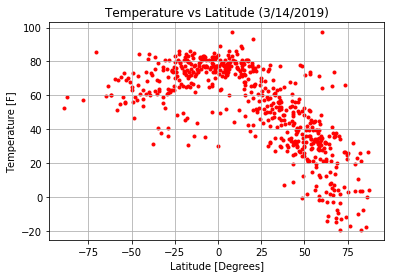

In [5]:
# Create a scatter plot of the Temperature vs the Latitude
plt.scatter(weather_report_df['Latitude'],weather_report_df['Temperature (F)'],\
            marker = ".", color = "red")
plt.xlabel("Latitude [Degrees]")
plt.ylabel("Temperature [F]")
plt.title("Temperature vs Latitude (3/14/2019)")
plt.grid()
plt.savefig("temp_vs_lat.png") # save plt as png to directory

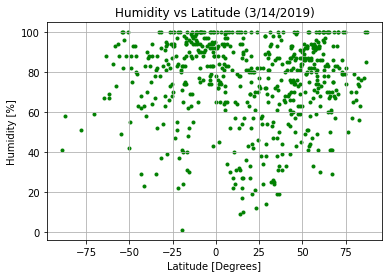

In [6]:
# Create a scatter plot of the Humidity vs the Latitude
plt.scatter(weather_report_df['Latitude'],weather_report_df['Humidity (%)'],\
            marker = ".", color = "green")
plt.xlabel("Latitude [Degrees]")
plt.ylabel("Humidity [%]")
plt.title("Humidity vs Latitude (3/14/2019)")
plt.grid()
plt.savefig("humidity_vs_lat.png") # save plt as png to directory

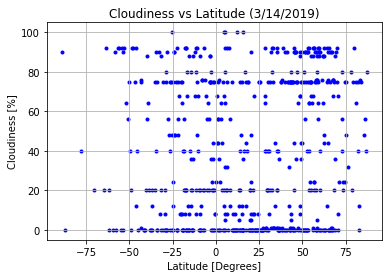

In [7]:
# Create a scatter plot of the Cloudiness vs the Latitude
plt.scatter(weather_report_df['Latitude'],weather_report_df['Cloudiness (%)'],\
            marker = ".", color = "blue")
plt.xlabel("Latitude [Degrees]")
plt.ylabel("Cloudiness [%]")
plt.title("Cloudiness vs Latitude (3/14/2019)")
plt.grid()
plt.savefig("cloudiness_vs_lat.png") # save plt as png to directory

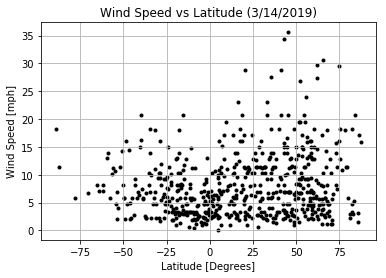

In [8]:
# Create a scatter plot of the Wind Speed vs the Latitude
plt.scatter(weather_report_df['Latitude'],weather_report_df['Wind Speed (mph)'],\
            marker = ".", color = "black")
plt.xlabel("Latitude [Degrees]")
plt.ylabel("Wind Speed [mph]")
plt.title("Wind Speed vs Latitude (3/14/2019)")
plt.grid()
plt.savefig("wind_speed_vs_lat.png") # save plt as png to directory

In [9]:
# Perform once at the end of notebook
plt.show()